<a href="https://www.kaggle.com/code/ayazlakho/global-temperature-anomaly-prediction?scriptVersionId=298717280" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/climate-change-earth-surface-temperature-data/GlobalTemperatures.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByState.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCountry.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv
/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByMajorCity.csv


## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")


## Load Kaggle Dataset

In [3]:
df = pd.read_csv("/kaggle/input/climate-change-earth-surface-temperature-data/GlobalLandTemperaturesByCity.csv")

df.head()


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


## Basic Cleaning

In [4]:
print("Shape:", df.shape)
print(df.isna().sum())

# Remove missing temperature rows
df = df.dropna(subset=["AverageTemperature"])

# Convert date
df["dt"] = pd.to_datetime(df["dt"])
df["year"] = df["dt"].dt.year
df["month"] = df["dt"].dt.month

df.head()


Shape: (8599212, 7)
dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,month
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743,11
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E,1744,4
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E,1744,5
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E,1744,6
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E,1744,7


## Global Mean Temperature Per Month

In [5]:
monthly_global = df.groupby("dt")["AverageTemperature"].mean().reset_index()

monthly_global = monthly_global.sort_values("dt")
monthly_global.head()


,dt,AverageTemperature
0,1743-11-01,4.882424
1,1744-04-01,9.737433
2,1744-05-01,12.685514
3,1744-06-01,16.868296
4,1744-07-01,18.844524


## Compute Temperature Anomaly

In [6]:
baseline = monthly_global[
    (monthly_global["dt"].dt.year >= 1951) &
    (monthly_global["dt"].dt.year <= 1980)
]["AverageTemperature"].mean()

monthly_global["anomaly"] = monthly_global["AverageTemperature"] - baseline

monthly_global.head()


,dt,AverageTemperature,anomaly
0,1743-11-01,4.882424,-12.905936
1,1744-04-01,9.737433,-8.050926
2,1744-05-01,12.685514,-5.102845
3,1744-06-01,16.868296,-0.920063
4,1744-07-01,18.844524,1.056165


## Visualize Climate Change Trend

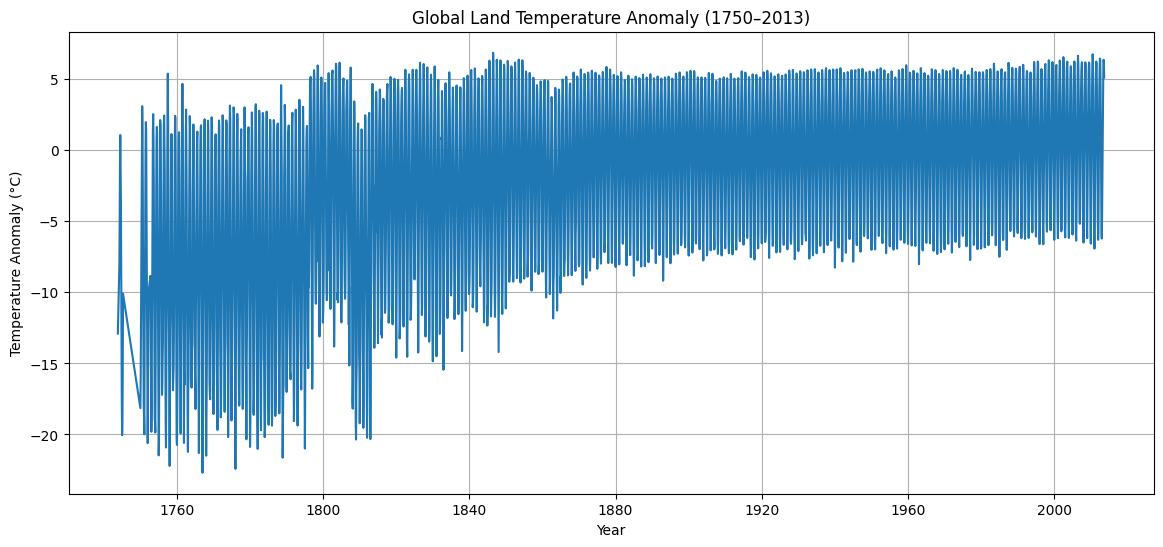

In [7]:
plt.figure(figsize=(14,6))
plt.plot(monthly_global["dt"], monthly_global["anomaly"])
plt.title("Global Land Temperature Anomaly (1750–2013)")
plt.xlabel("Year")
plt.ylabel("Temperature Anomaly (°C)")
plt.grid(True)
plt.show()


## Rolling Mean (Climate Smoothing)

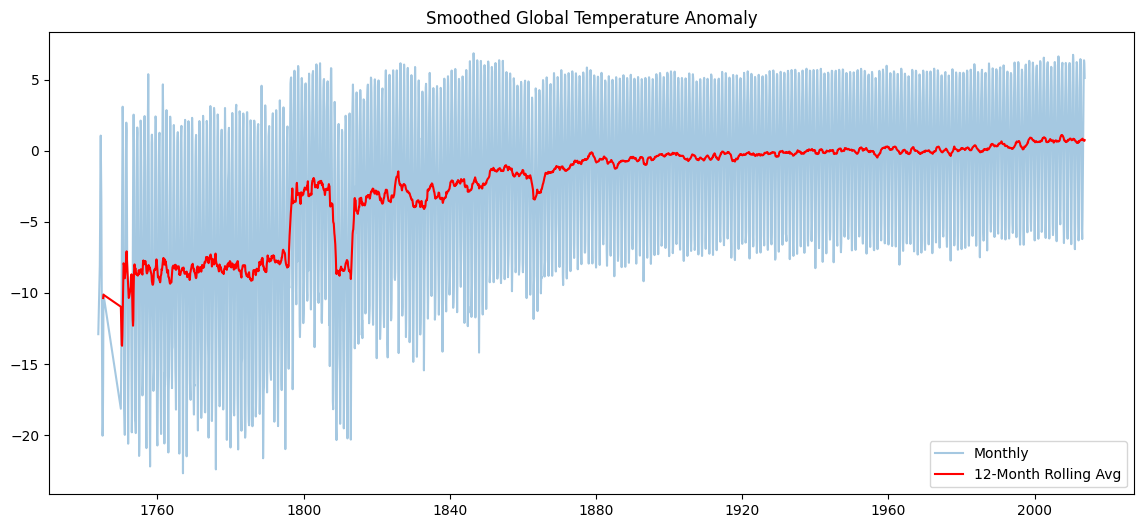

In [8]:
monthly_global["rolling_12"] = monthly_global["anomaly"].rolling(12).mean()

plt.figure(figsize=(14,6))
plt.plot(monthly_global["dt"], monthly_global["anomaly"], alpha=0.4, label="Monthly")
plt.plot(monthly_global["dt"], monthly_global["rolling_12"], color="red", label="12-Month Rolling Avg")
plt.legend()
plt.title("Smoothed Global Temperature Anomaly")
plt.show()


## Convert to Supervised ML Format

In [9]:
def create_sequences(data, window=6):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

anomaly_values = monthly_global["anomaly"].values

X, y = create_sequences(anomaly_values, window=6)

print(X.shape, y.shape)


(3161, 6) (3161,)


## Train/Test Split

In [10]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


## Baseline Model: Linear Regression

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

print("Linear Regression MAE:", mean_absolute_error(y_test, lr_preds))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_preds)))


Linear Regression MAE: 0.7201785667434516
Linear Regression RMSE: 0.8860086546907915


## Advanced Model: Random Forest

In [12]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)

print("Random Forest MAE:", mean_absolute_error(y_test, rf_preds))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_preds)))


Random Forest MAE: 0.8235796544828513
Random Forest RMSE: 1.235670222574386


## Compare Predictions

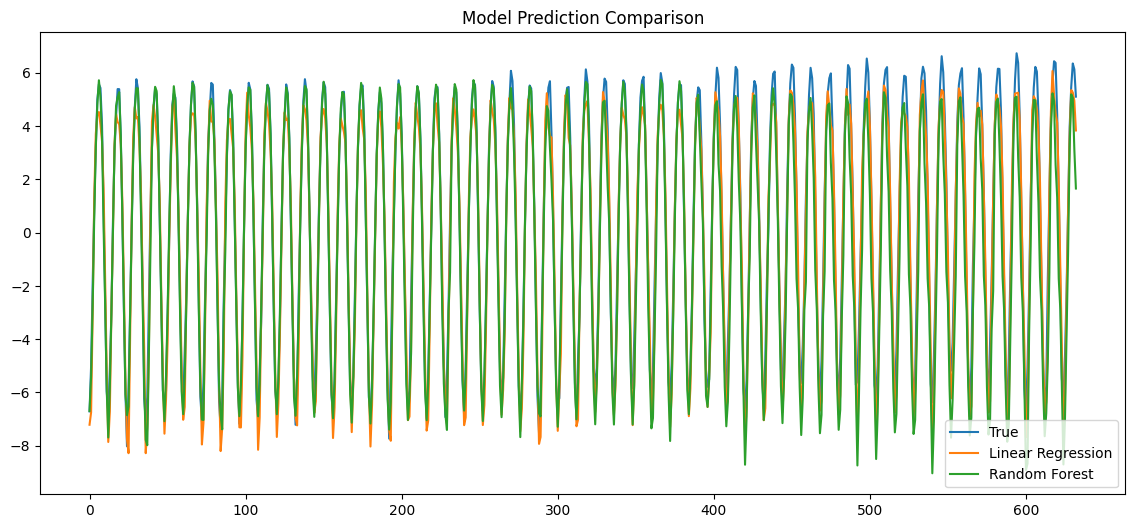

In [13]:
plt.figure(figsize=(14,6))
plt.plot(y_test, label="True")
plt.plot(lr_preds, label="Linear Regression")
plt.plot(rf_preds, label="Random Forest")
plt.legend()
plt.title("Model Prediction Comparison")
plt.show()


## Feature Importance (Scientific Insight)

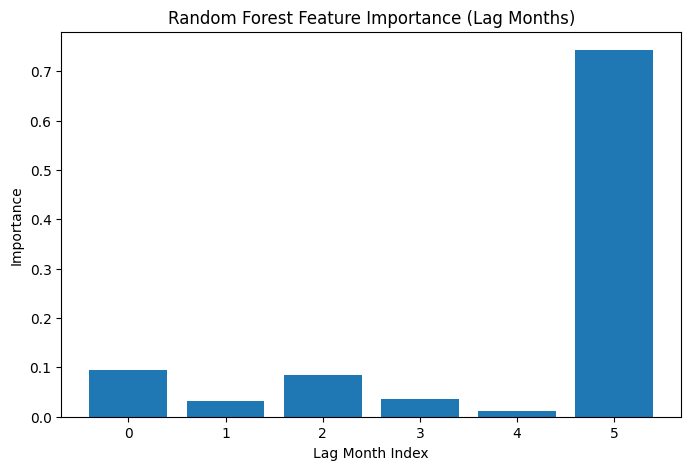

In [14]:
importances = rf.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(range(len(importances)), importances)
plt.title("Random Forest Feature Importance (Lag Months)")
plt.xlabel("Lag Month Index")
plt.ylabel("Importance")
plt.show()


## Trend Quantification (Climate Science Component)

In [15]:
monthly_global["time_index"] = np.arange(len(monthly_global))

trend_model = LinearRegression()
trend_model.fit(monthly_global[["time_index"]], monthly_global["anomaly"])

slope = trend_model.coef_[0]
print("Warming trend per month:", slope)
print("Approx warming per decade:", slope * 120)


Warming trend per month: 0.003035509694192626
Approx warming per decade: 0.36426116330311514
